In [513]:
import numpy as np
import random
import networkx as nx

In [514]:
class Board():
    def __init__(self, state):
        self._state = state
        self.marker_to_value = {'-': 0, 'X': 1, 'O': 2}
        self.value_to_marker = {0: '-', 1: 'X', 2: 'O'}
        
    @property
    def state(self):
        """Get the current state of the board."""
        return self._state
    
    @staticmethod
    def moves_available(state):
        return list(zip(*np.where(state==0)))
    
    
    def update_board(self, move, marker):
        marker_to_value = {'-': 0, 'X': 1, 'O': 2}
        # fail if move is not available
        assert self.state[move[0]][move[1]] == 0
        assert marker in ['X', 'O']
        self.state[move[0]][move[1]] = marker_to_value[marker]
        
    @staticmethod
    def draw(state):
        """
        Prints the board
        """
        size = state.shape[0]
        value_to_marker = {0: '-', 1: 'X', 2: 'O'}
        for m in range(size):
            print('|'.join([value_to_marker[state[m][n]] for n in range(size)]))
            if m != size-1:
                print('-'*((size*2)-1))
    
    @staticmethod    
    def is_finished(state):
        """
        Check of board is in a winning state
        Return None if not a winning state, otherwise
        Return the marker of the winning player (1 or 2) or 'draw' if draw
        """
        value_to_marker = {0: '-', 1: 'X', 2: 'O'}
        size = state.shape[0]
        rows = [state[i,:] for i in range(size)]
        cols = [state[:,j] for j in range(size)]
        diag = [np.array([state[i,i] for i in range(size)])]
        cross_diag = [np.array([state[(size-1)-i,i] for i in range(size)])]
        lanes = np.concatenate((rows, cols, diag, cross_diag))
        for lane in lanes:
            if set(lane) == {1}:
                print(f"player {value_to_marker[1]} wins!")
                return value_to_marker[1]
            if set(lane) == {2}:
                print(f"player {value_to_marker[2]} wins!")
                #self.draw()
                return value_to_marker[2]
        
        # check for draw
        if np.all(state!=0):
            print('Draw!')
            return 'draw'
        
        # game still in progress
        return None


In [515]:
class RandomPlayer():

    def __init__(self, marker):
        self.marker = marker
        
    def move(self, board):
        
        moves_available = board.moves_available(board.state)
        move = random.choice(moves_available)
        return move

In [516]:
board = Board(state=np.zeros((3,3), dtype=int))

player1 = RandomPlayer('X')
player2 = RandomPlayer('O')

turns = 0
active_player = player1
inactive_player = player2
while not board.is_finished(board.state):
    move = active_player.move(board)
    board.update_board(move=move, marker=active_player.marker)
    turns += 1
    if turns > 20:
        break
    # switch players
    active_player, inactive_player = inactive_player, active_player
board.draw(board.state)

player O wins!
X|-|O
-----
-|O|X
-----
O|-|X


In [517]:
###############################

In [518]:
def play_move(state, move, marker):
    new_state = np.copy(state)
    marker_to_value = {'-': 0, 'X': 1, 'O': 2}
    # fail if move is not available
    assert new_state[move[0]][move[1]] == 0
    assert marker in ['X', 'O']
    new_state[move[0]][move[1]] = marker_to_value[marker]
    return new_state

In [591]:
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

def draw_graph(G, fig_size = (5,5), node_label=None, edge_label=None):
    f, ax = plt.subplots(figsize=fig_size)
    G.graph.setdefault('graph', {})['rankdir'] = 'LR'
    # color nodes based on winner
    node_color = []
    node_size = 50
    for node in G.nodes(data=True):
        if node[1]['finished']:
            if node[1]['result'] == 'won':
                node_color.append('green')
            elif node[1]['result'] == 'lost':
                node_color.append('red')
            elif node[1]['result'] == 'draw':
                node_color.append('yellow')
            else:
                node_color.append('blue')
        else:
            node_color.append('lightgray')
    pos = graphviz_layout(G, prog='dot')
    if node_label:
        nx.draw_networkx(G, pos=pos, labels=nx.get_node_attributes(G, node_label), node_color=node_color, node_size=node_size)
    else:
        nx.draw_networkx(G, pos=pos, with_labels=False, node_color=node_color, node_size=node_size)   
    if edge_label:
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=nx.get_edge_attributes(G, edge_label))
        
    plt.show()
    return

def search(board, player, max_depth=3): # -> DiGraph
    """
    Run game simulations from current game state to a maximum number
    of moves ahead (max_depth)
    Return the graph of possible moves and outcomes
    state = [(1,1), (1,1)]
    Assume player is player to be maximized
    """
    player_marker = player.marker
    opponent_marker = {'X': 'O', 'O': 'X'}.get(player.marker)
    
    turn_marker = player.marker
    non_turn_maker = opponent_marker
    
    depth = 0
    n = 0 # node label which also serves as a node counter

    G = nx.DiGraph()
    G.add_node(0, finished=board.is_finished(board.state), player=turn_marker, state=board.state)
    
    # First branch in look ahead
    newleavelist=[]
    
    for move in board.moves_available(state=board.state):   
        # Do move   
        new_state = play_move(state=board.state, move=move, marker=turn_marker)
        # Check if game is finished after move
        is_finished = board.is_finished(new_state)

        # Add move node to graph
        n=n+1
        G.add_node(n, finished=is_finished, player=non_turn_maker, state=new_state)
        G.add_edge(0, n, move=move)
        if is_finished:
            G.nodes[n]['result'] = {player_marker:'won', opponent_marker:'lost', 'draw':'draw'}.get(is_finished)
            continue
        newleavelist.append(n)
    
    depth+=1
    # Subsequent branches
    while depth < max_depth:
        # switch turns
        turn_marker, non_turn_maker = non_turn_maker, turn_marker
        leavelist = newleavelist[:]
        newleavelist = []
        for leave in leavelist:
            # Get parent state
            parent_state = G.nodes(data=True)[leave]['state'] #G.nodes(data=True)[list(G.pred[leave])[0]]['state']
            for move in board.moves_available(parent_state):
                # Do move   
                new_state = play_move(parent_state, move=move, marker=turn_marker)
                # Check if game is finished after move
                is_finished = board.is_finished(new_state)
                # Add move node to graph
                n=n+1
                G.add_node(n, finished=is_finished, player=non_turn_maker, state=new_state)
                G.add_edge(leave, n, move=move)
                if is_finished:
                    G.nodes[n]['result'] = {player_marker: 'won', opponent_marker: 'lost', 'draw': 'draw'}.get(is_finished)
                    continue  
                newleavelist.append(n)
        depth=depth+1
    return G    



In [618]:
player1 = RandomPlayer('X')
player2 = RandomPlayer('O')
board = Board(np.array([[2,0,0],[0,0,0],[2,0,0]]))
board.draw(board.state)

O|-|-
-----
-|-|-
-----
O|-|-


In [717]:
G = search(board=board, player=player1, max_depth=2)

player O wins!
player O wins!
player O wins!
player O wins!
player O wins!
player O wins!


In [718]:
#draw_graph(G, fig_size=(5,20))
#draw_graph(G, fig_size=(5,5), node_label='result', edge_label='move')

# Minimax

In [719]:
def minimax(G):
    """Perform minimax from node n on a NetworkX graph G.
    Assume node n is a maximiser node.
    Return best move
    """

    maxplayer = True
    minplayer = False
    def _minimax(G, n, player):

        # Base case, winning node found
        if G.nodes[n]['finished']:
            if G.nodes[n]['result'] == 'won':
                score = 100
            elif G.nodes[n]['result'] == 'lost':
                score = -100
            elif G.nodes[n]['result'] == 'draw':
                score = 0
            else:
                assert True == False
                
            G.nodes[n].update({'score': score})
            return score

        if player == maxplayer:
            bestv = -1
            for child in G.successors(n):
                v = _minimax(G, child, minplayer)
                G.nodes[child].update({'score': v})
                bestv = max(bestv, v)
        else:
            bestv = 1
            for child in G.successors(n):
                v = _minimax(G, child, maxplayer)
                G.nodes[child].update({'score': v})
                bestv = min(bestv, v)
        return bestv

    # Find the best first move from the given node
    # Assume given node n is a maximiser node.
    best_node = None
    bestv = -1

    for child in G.successors(0):
        v = _minimax(G, child, minplayer)
        G.nodes[child].update({'score': v})

        if v > bestv:
            best_node = child
            bestv = v

    if best_node:
        return G, G.pred[best_node][0]['move']
    
    else:
        # select a random node
        best_nodes = [n[0] for n in G.subgraph(G.successors(0)).nodes(data=True) if n[1]['score'] == -1]
        best_node = random.choice(best_nodes)
        return G, G.pred[best_node][0]['move']

In [720]:
G, move = minimax(G)
move

(1, 0)

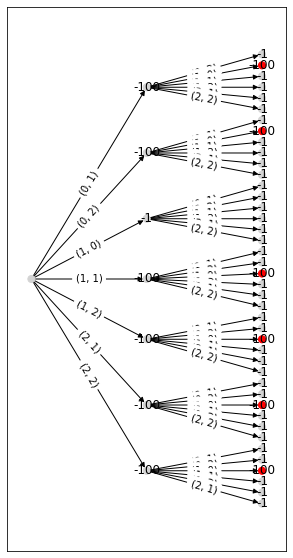

In [721]:
draw_graph(G, fig_size=(5,10), node_label='score', edge_label='move')

In [ ]:
# class Game():
#     def __init__(self, player1, player2):
#         self.player1 = player1
#         self.player2 = player2
#         self._active_player = player1
#         self._inactive_player = player2
#         self._turns = 1
#         self.player1.idx = 1 # test that these can be switched without affecting game score
#         self.player2.idx = 0
        
#     @property
#     def active_player(self):
#         return self._active_player
    
#     @property
#     def inactive_player(self):
#         return self._inactive_player
    
#     @property
#     def turns(self):
#         return self._turns
    
#     def end_of_turn(self):
#         '''Switch players and increment turn count'''
#         self._active_player, self._inactive_player = self._inactive_player, self._active_player
#         self._turns += 1